In [2]:
!pip install proplot
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np

train = pd.read_csv('../data/kaggle_house_pred_train.csv')
test = pd.read_csv('../data/kaggle_house_pred_test.csv')
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [13]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import proplot as pplt

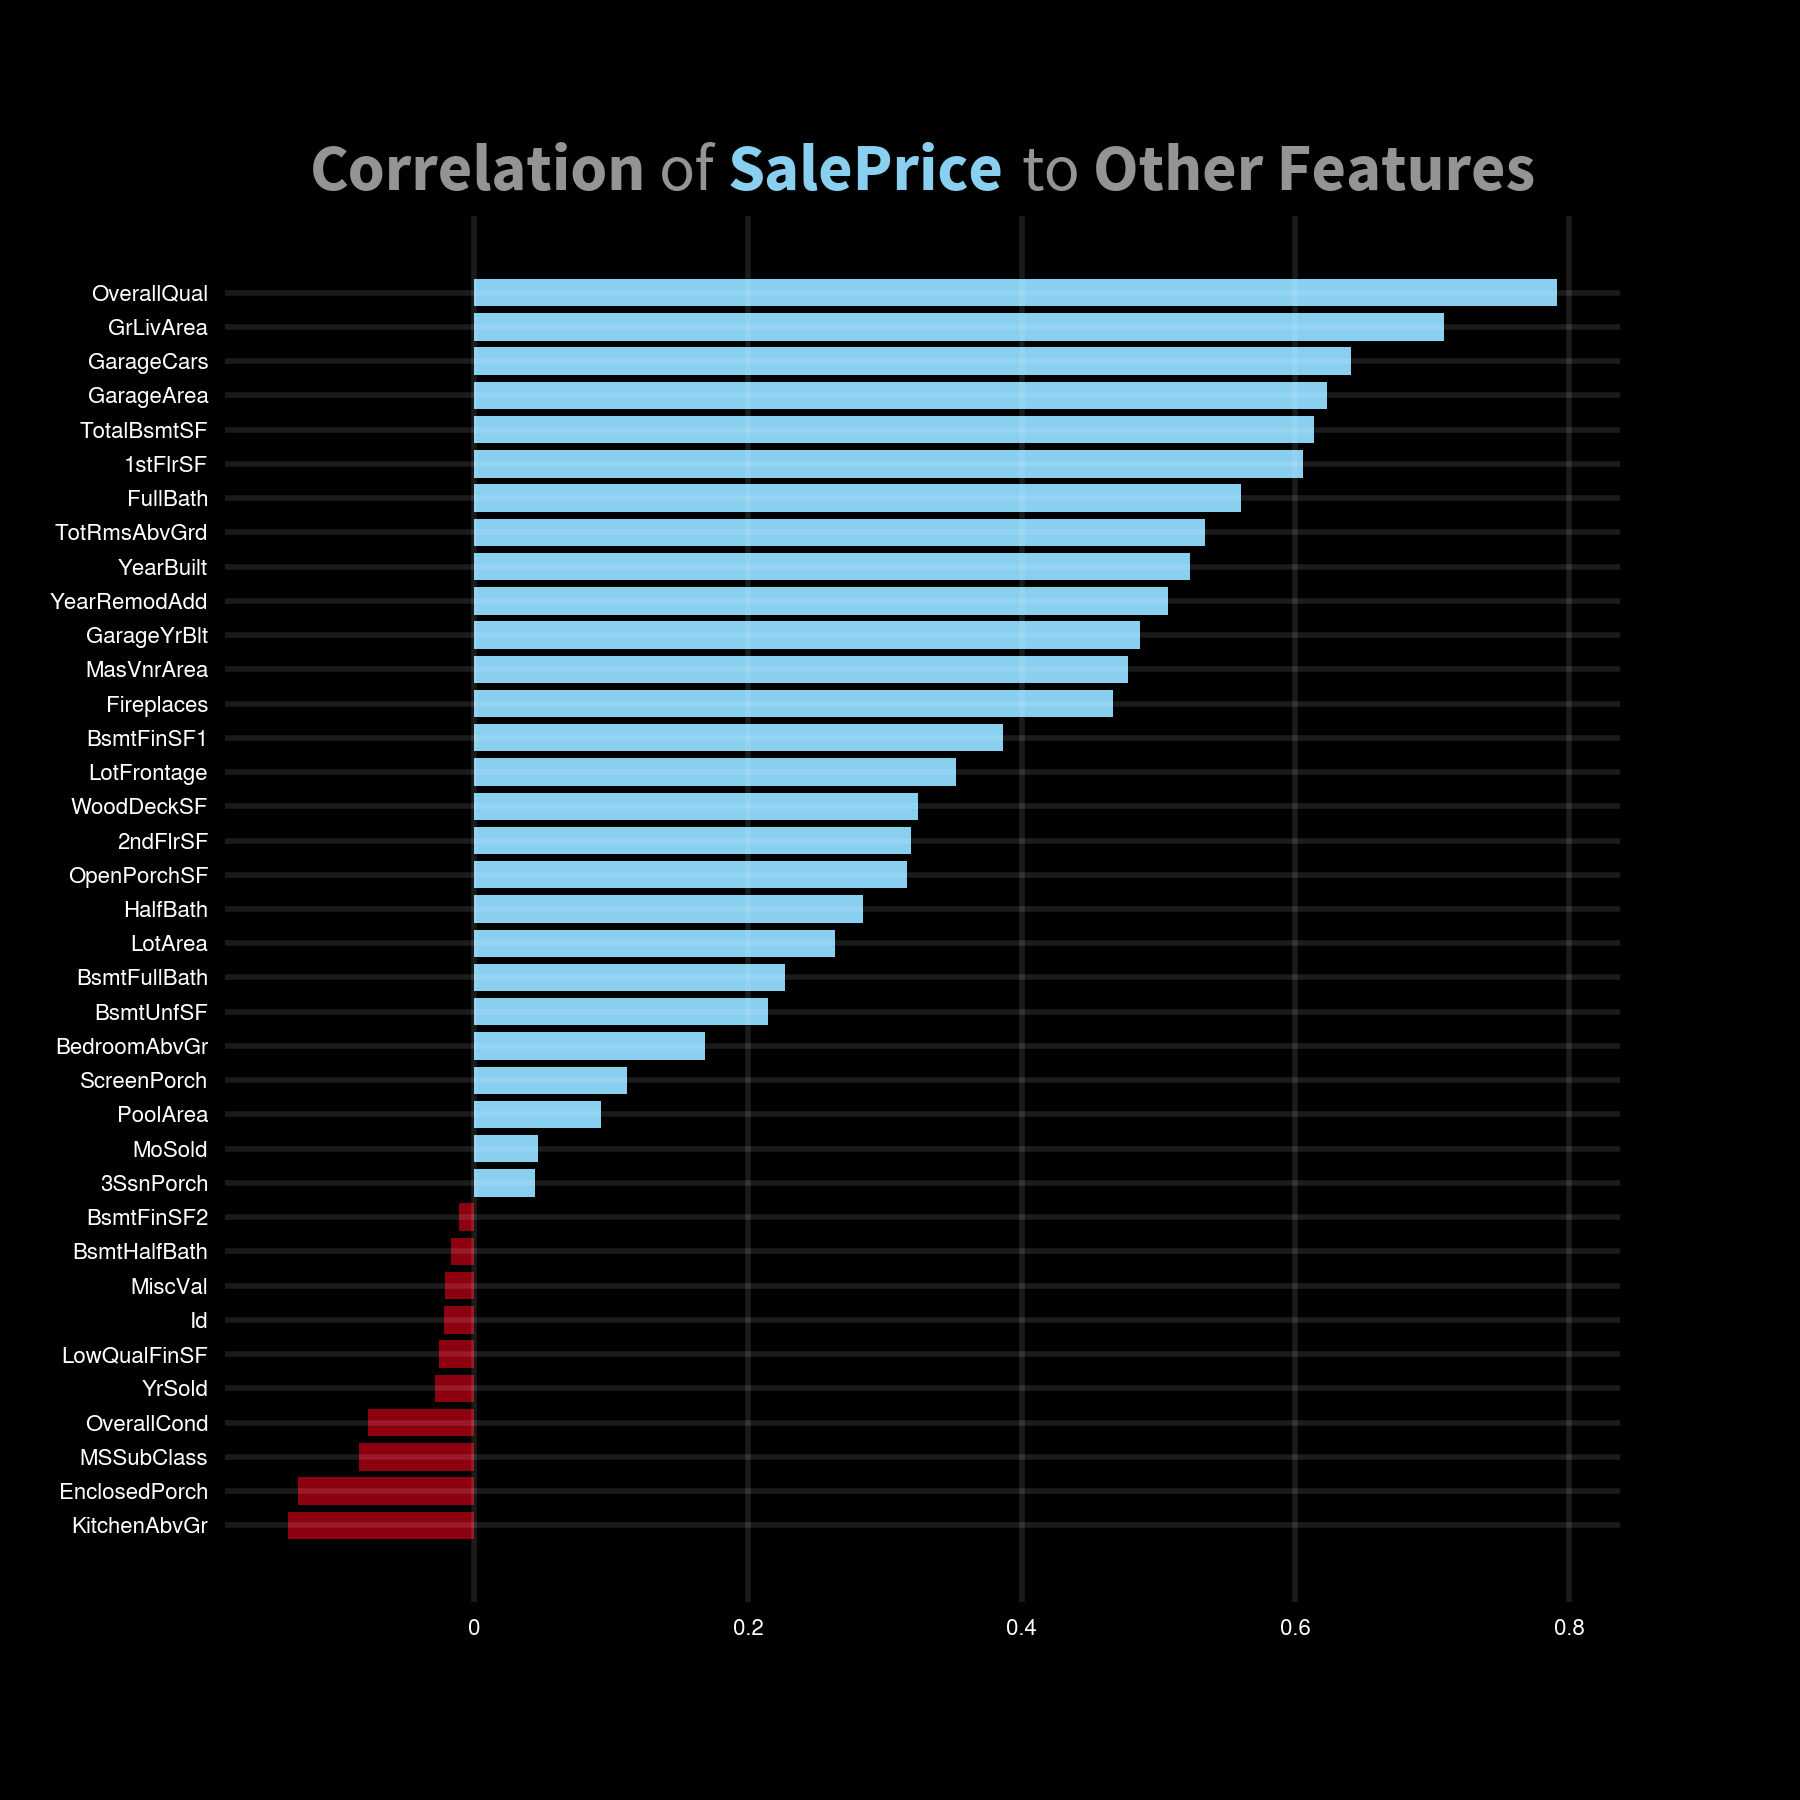

In [34]:
# compute the correlation between numerical features 

corr = train[train.columns].corr()['SalePrice'].sort_values(ascending=True).to_frame()
corr = corr.drop(corr[corr.SalePrice > 0.99].index)

# Visualization
fig, ax = plt.subplots(figsize =(9, 9))
fig.patch.set_facecolor('black')
ax.patch.set_facecolor('black')

ax.barh(corr.index, corr.SalePrice, align='center', color = np.where(corr['SalePrice'] < 0, 'crimson', '#89CFF0'))

ax.tick_params(axis='both', which='major', labelsize=8)
ax.yaxis.set_label_coords(0, 0)

ax.grid(color='white', linewidth=2)

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes spines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Font
mpl.rcParams['font.family'] = 'Source Sans Pro'

plt.text(-0.12, 39, "Correlation", size=24, color="grey", fontweight="bold");
plt.text(0.135, 39, "of", size=24, color="grey");
plt.text(0.185, 39, "SalePrice", size=24, color="#89CFF0", fontweight="bold");
plt.text(0.4, 39, "to", size=24, color="grey");
plt.text(0.452, 39, "Other Features", size=24, color="grey", fontweight="bold");

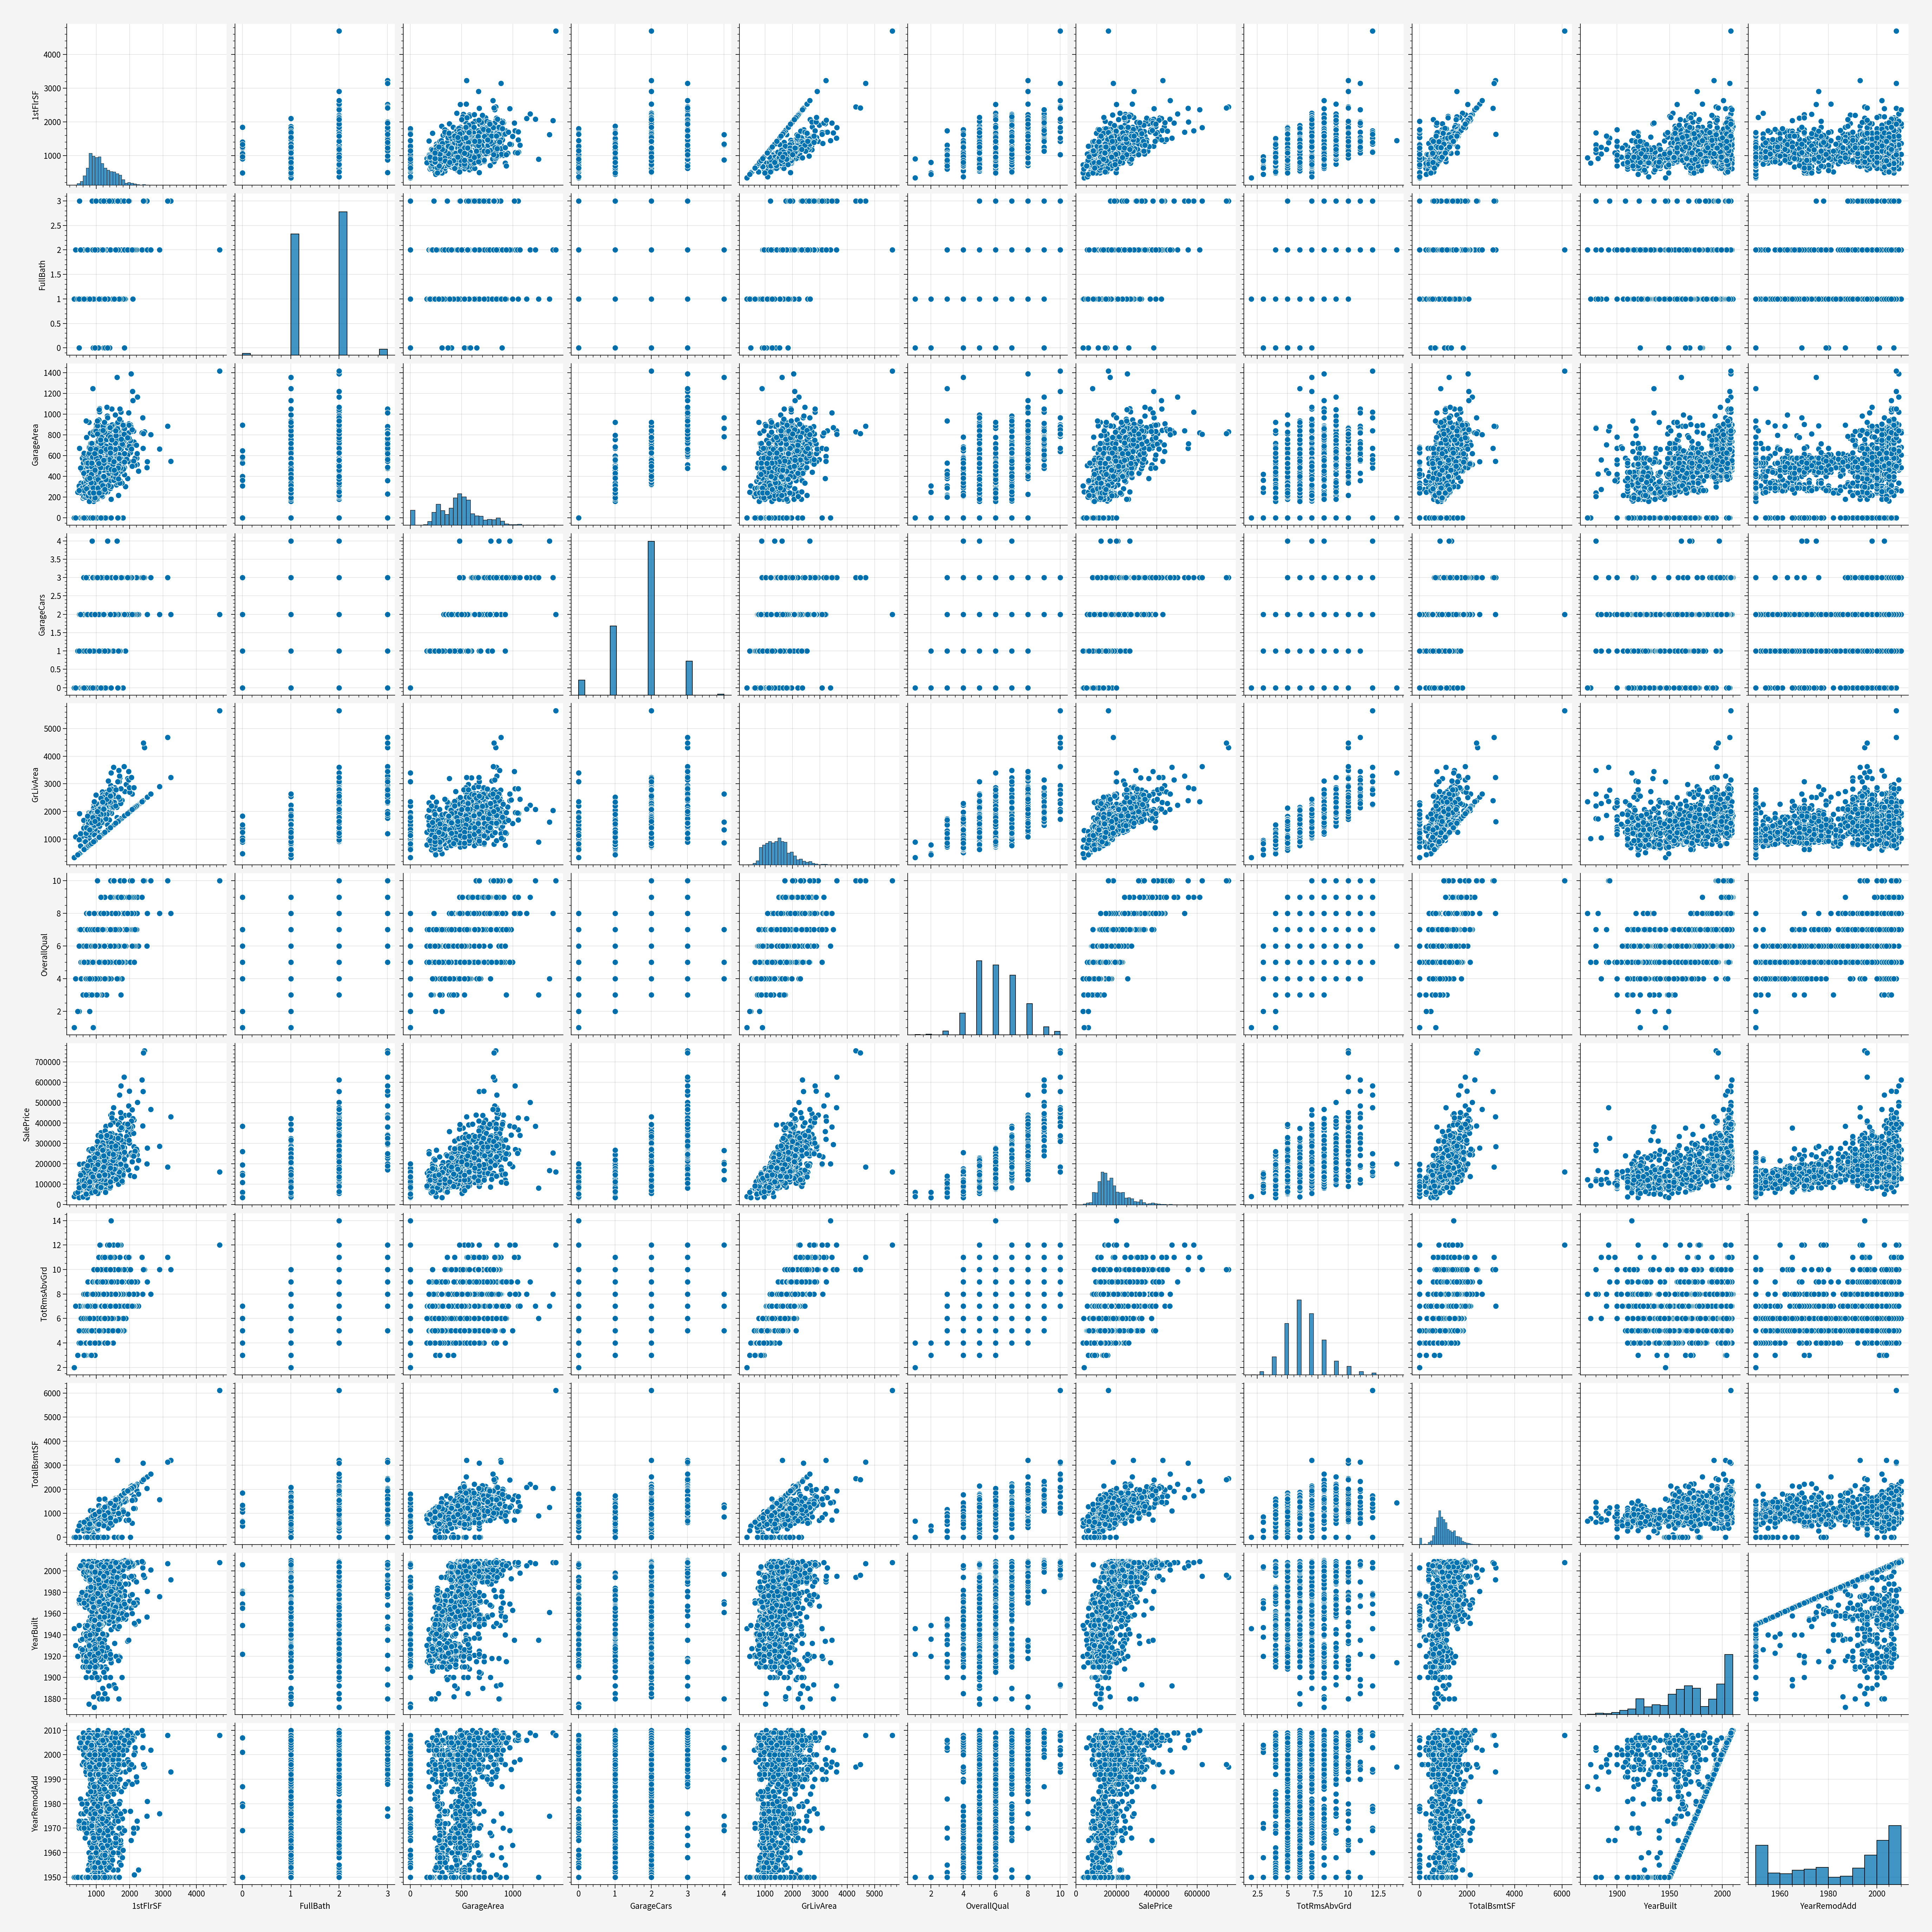

In [36]:
# pairplot top 10 correlation features + target
top_corr = corr['SalePrice'].sort_values(ascending=False).head(10).index
top_corr = top_corr.union(['SalePrice'])

sns.pairplot(train[top_corr])

In [37]:
print('Training Shape:', train.shape)
print('Test Shape:', test.shape)

Training Shape: (1460, 81)
Test Shape: (1459, 80)


In [38]:
# let's save the ID of each dataset
train_id = train['Id']
test_id = test['Id']
del train['Id']
del test['Id']

In [39]:
train1 = train.copy()
train1 = train1.drop(train1[(train1['GarageArea']>1200) & (train1['SalePrice']<300000)].index)
train1 = train1.drop(train1[(train1['GrLivArea']>4000) & (train1['SalePrice']<300000)].index)
train1 = train1.drop(train1[(train1['TotalBsmtSF']>5000)].index)
print('Outliers removed =' , train.shape[0] - train1.shape[0])

Outliers removed = 5


In [40]:
# Split X and y (in train dataset)
X = train1.drop('SalePrice', axis=1)
y = train1['SalePrice'].to_frame()

# Add variable
X['train'] = 1
test['train'] = 0

# Combining train and test for data cleaning 
df = pd.concat([test, X])

In [41]:
# Do we have duplicates?
print('Number of Duplicates:', len(df[df.duplicated()]))

# Do we have missing values?
print('Number of Missing Values:', df.isnull().sum().sum())

Number of Duplicates: 0
Number of Missing Values: 13945


In [42]:
print('Missing Values per Column:')
df.isnull().sum().sort_values(ascending=False).head(25)

Missing Values per Column:


PoolQC          2905
MiscFeature     2810
Alley           2716
Fence           2343
FireplaceQu     1419
LotFrontage      485
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
BsmtUnfSF          1
KitchenQual        1
dtype: int64

In [45]:
df['PoolQC'] = df['PoolQC'].fillna('None')
df['MiscFeature'] = df['MiscFeature'].fillna('None')
df['Alley'] = df['Alley'].fillna('None')
df['Fence'] = df['Fence'].fillna('None')
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda i: i.fillna(i.median()))

# Let's take a look at the "Garage" features
garage_cols = [col for col in df if col.startswith('Garage')]

# For the numerical features:
for i in df[garage_cols].select_dtypes(exclude='object').columns:
    df[i] = df[i].fillna(0)

# For the categorical features:
for i in df[garage_cols].select_dtypes(include='object').columns:
    df[i] = df[i].fillna('None')

bsmt_cols = [col for col in df if col.startswith('Bsmt')]

# For the numerical features:
for i in df[bsmt_cols].select_dtypes(exclude='object').columns:
    df[i] = df[i].fillna(0)

# For the categorical features:
for i in df[bsmt_cols].select_dtypes(include='object').columns:
    df[i] = df[i].fillna('None')
    
mas_cols = [col for col in df if col.startswith('Mas')]

# For the numerical features:
for i in df[mas_cols].select_dtypes(exclude='object').columns:
    df[i] = df[i].fillna(0)

# For the categorical features:
for i in df[mas_cols].select_dtypes(include='object').columns:
    df[i] = df[i].fillna('None')